**Лабораторна робота №1: Огінська Марина, Гобела Максим**

# Вступна частина

У даній лабораторній роботі нам було запропоновано розробити чотири алгоритми (Пріма, Крускала, Беллмана-Форда та Флойда-Воршала) і функцію, яка розподілятиме певну задану нам інформацію у бінарне дерево пошуку, а також порівняти їхню роботу з роботою функцій бібліотеки NetworkX.
Спочатку ми імпортуємо ті бібліотеки Python, які нам потрібні.

In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [2]:
import time
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby
from tqdm import tqdm

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance

import numpy.typing as npt

import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split

import graphviz

# Основна частина

## 1. Алгоритми

Ми розробили три алгоритми: Пріма, Крускала та Беллмана-Форда. Але спочатку за допомогою уже даної нам функцію створимо рандомний граф для Пріма та Крускала.

### Завдання 1

#### Генерування графа

In [3]:
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

In [ ]:
G = gnp_random_connected_graph(10, 1, False, True)

#### Алгоритм Крускала

Алгоритм Крускала поялгає у пошуку мінімального каркасу для графу. Його суть полягає у пошуку найменшого ребра щоразу. Важливо, щоб обрані ребра не змогли утворити між собою цикл.

##### Наш код + опис

In [5]:
def get_vertex_set_k(vertex: tuple[int, int], disjoint_vertex_sets: set[int]) -> set[int] | None:
    """
    Finds and returns the disjoint set containing the given vertex.

    Parameters:
    vertex (tuple[int, int]): A tuple representing a vertex in the graph.
    disjoint_vertex_sets (set[int]): A set of disjoint sets representing the connected components of the graph.

    Returns:
    set[int]: The disjoint set containing the given vertex.
    None: If the vertex is not found in any disjoint set.
    """
    for vertex_set in disjoint_vertex_sets:
        if vertex in vertex_set:
            return vertex_set
    return None


def get_min_spanning_tree_k(G: nx.Graph) -> set[tuple[int, int]]:
    """
    Computes the Minimum Spanning Tree (MST) of the graph using Kruskal's algorithm.

    Parameters:
    G (nx.Graph): A networkx graph object representing the graph.

    Returns:
    set[tuple[int, int]]: A set of edges that form the Minimum Spanning Tree (MST).

    Algorithm:
    1. Sort edges by weight.
    2. Initialize disjoint sets for each vertex.
    3. Iterate through sorted edges and add edges to MST if they connect different sets.
    4. Merge the sets of the vertices of the added edge.
    5. Stop when all vertices are connected.
    """
    edges = {(v1, v2): w["weight"] for v1, v2, w in G.edges(data=True)}
    edges = {v: w for v, w in sorted(edges.items(), key=lambda x: x[1])}

    min_spanning_tree = set()
    disjoint_vertex_sets = [{v} for v in G.nodes()]

    for edge in edges:
        set_v, set_w = get_vertex_set_k(edge[0], disjoint_vertex_sets), get_vertex_set_k(edge[1], disjoint_vertex_sets)
        if set_v == set_w:
            continue

        min_spanning_tree.add(edge)
        disjoint_vertex_sets.remove(set_v)
        disjoint_vertex_sets.remove(set_w)
        disjoint_vertex_sets.append(set_v | set_w)

        if len(disjoint_vertex_sets) == 1:
            break
    return min_spanning_tree


def visualize_mstk(G: nx.Graph) -> None:
    """
    Visualizes the Minimum Spanning Tree built using Kruskal’s algorithm (MST) of the graph using networkx.

    Parameters:
    G (nx.Graph): A networkx graph object representing the graph.

    Returns:
    None
    """
    tree = nx.Graph()
    tree.add_edges_from(get_min_spanning_tree_k(G))
    nx.draw(tree, node_color='lightblue', with_labels=True, node_size=500)

*   Перша функція, get_vertex_set_k(), призначено для того, щоб у головній частині за допомогою неї уникнути циклів;
*   Друга функція, get_min_spanning_tree_k(), є основною, де і здйснюється увесь алгоритм Крускала. Функція ітерується від найлегшого до найтяжчого ребра, вичисляючи, чи можна додати ребро до каркасу, чи ні;
*   Третя функція, visualize_mstk(), візуалізує каркас графу за допомогою бібліотеки NetworkX.

##### Візуалізація

Візуалізація графа, ізоморфного каркасу графа G.

In [ ]:
visualize_mstk(G)

#### Алгоритм Пріма

Хоча і здається, що алгоритми Крускала та Пріма однакові, проте є суттєва відмінність: алгоритм Пріма, на відміну від Крускала бере лише ті ребра, які є суміжними з уже обраними ребрами, тоді як алгоритм Крускала нехтує суміжністю ребер.

##### Наш код + опис


In [7]:
def get_min_weighted_edge_p(edges: dict[int: tuple[int, int]], visited_nodes: set[int]) -> tuple[tuple, int] | None:
    """
    Finds the minimum weighted edge that connects an unvisited vertex to the visited vertices.

    Parameters:
    edges (dict[int, list[tuple[int, int]]]): A dictionary where keys are vertex indices and values are lists of tuples,
                                              each containing an adjacent vertex and the edge weight.
    visited_nodes (set[int]): A set of vertices that have already been visited.

    Returns:
    tuple[tuple[int, int], int] | None: The minimum weighted edge as a tuple (u, v) and its weight, or None if no valid edge exists.
    """

    min_weight = float('inf')

    for node in visited_nodes:
        for adj_node, weight in edges[node]:
            if weight < min_weight and adj_node not in visited_nodes:
                min_weight = weight
                valid_edge = (node, adj_node)

    if not valid_edge:
        return None

    return valid_edge


def get_min_spanning_tree_p(G: nx.Graph) -> set[tuple[int, int]]:
    """
    Computes the Minimum Spanning Tree (MST) of the given graph using Prim's algorithm.

    Parameters:
    G (nx.Graph): A NetworkX graph where edges have a "weight" attribute.

    Returns:
    set[tuple[int, int]]: A set of edges forming the MST.

    Algorithm:
    1. Initialize an empty set for the MST and choose the edge with the smallest weight.
    2. Add the edge to the MST and mark its nodes as visited.
    3. Iteratively find the minimum weighted edge connecting a visited node to an unvisited node.
    4. Repeat until all nodes are included in the MST.
    """

    edges = {}
    min_weight = float('inf')

    for v1, v2, w in G.edges(data=True):
        if v1 not in edges:
            edges[v1] = []
        if v2 not in edges:
            edges[v2] = []

        weight = w["weight"]

        edges[v1].append((v2, weight))
        edges[v2].append((v1, weight))

        if weight < min_weight:
            min_weight = weight
            valid_edge = (v1, v2)

    visited_nodes = set(valid_edge)
    min_spanning_tree = set()

    min_spanning_tree.add(valid_edge)

    while len(visited_nodes) < len(G.nodes()):
        min_edge = get_min_weighted_edge_p(edges, visited_nodes)
        min_spanning_tree.add(min_edge)
        visited_nodes.update(min_edge)

    return min_spanning_tree


def visualize_mstp(G: nx.Graph) -> None:
    """
    Visualizes the Minimum Spanning Tree (MST) of the given graph using NetworkX.

    Parameters:
    G (nx.Graph): A NetworkX graph where edges have a "weight" attribute.

    Returns:
    None
    """

    tree = nx.Graph()
    tree.add_edges_from(get_min_spanning_tree_p(G))
    nx.draw(tree, node_color='lightblue', with_labels=True, node_size=500)

*    Перша функція, get_min_weighted_edge_p(), вичисляє ребро з найменшою вагою у графі за допомогою порівнянь ваги ребер;
*    Друга функція, get_min_spanning_tree_p(), є основною та виконує весь алгоритм Пріма. Суть полягає у пошуку мінімального ребра, а потім сусіжних до нього ребер, допоки не будуть обійдені усі вершини графу.
*    Третя функція, visualize_mstp(), візуалізує граф, який був даний йому.

##### Візуалізація

Візуалізація графа, ізоморфного каркасу графа G.

In [ ]:
visualize_mstp(G)

#### Порівняння алгоритмів Крускала та Пріма

Для порівняння двох алгоритмів була розроблена спеціальна функція, яка буде генерувати граф і порівнювати час обробки нашого коду з кодом NetworkX.

In [ ]:
def compare_algorithms(num_of_nodes: int, completeness: float, iterations: int = 100):
    kruskal_times = []
    prim_times = []
    nx_kruskal_times = []
    nx_prim_times = []

    with tqdm(total=iterations, desc=f"Processing {num_of_nodes} nodes, {completeness} completeness") as pbar:
        for _ in range(iterations):
            G = gnp_random_connected_graph(num_of_nodes, completeness)

            # Timing our implementation of Kruskal's algorithm
            start_time = time.time()
            get_min_spanning_tree_k(G)
            kruskal_times.append(time.time() - start_time)

            # Timing our implementation of Prim's algorithm
            start_time = time.time()
            get_min_spanning_tree_p(G)
            prim_times.append(time.time() - start_time)

            # Timing NetworkX Kruskal's algorithm
            start_time = time.time()
            nx_kruskal_tree = nx.minimum_spanning_tree(G, algorithm="kruskal")
            nx_kruskal_times.append(time.time() - start_time)

            # Timing NetworkX Prim's algorithm
            start_time = time.time()
            nx_prim_tree = nx.minimum_spanning_tree(G, algorithm="prim")
            nx_prim_times.append(time.time() - start_time)

            pbar.update(1)  # Update progress bar

    return {
        "graph": G,
        "kruskal_times": kruskal_times,
        "prim_times": prim_times,
        "nx_kruskal_times": nx_kruskal_times,
        "nx_prim_times": nx_prim_times,
    }

# Store results for different graph sizes and densities
results = {}

for num_nodes in [50, 100]:
    for completeness in [0.5, 0.7, 1.0]:
        key = f"{num_nodes} nodes, {completeness} completeness"
        results[key] = compare_algorithms(num_nodes, completeness, iterations=100)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

labels = list(results.keys())  # Extract graph size & completeness labels
data = np.array([
    [np.mean(res[algo]) for algo in ["kruskal_times", "prim_times", "nx_kruskal_times", "nx_prim_times"]]
    for res in results.values()
])

for i, algo in enumerate(["Our Kruskal", "Our Prim", "NetworkX Kruskal", "NetworkX Prim"]):
    ax.plot(labels, data[:, i], marker='o', label=algo)

ax.set_ylabel("Execution Time (s)")
ax.set_title("Comparing Prim and Kruskal")
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.grid()
plt.show()

##### Результати порівняння

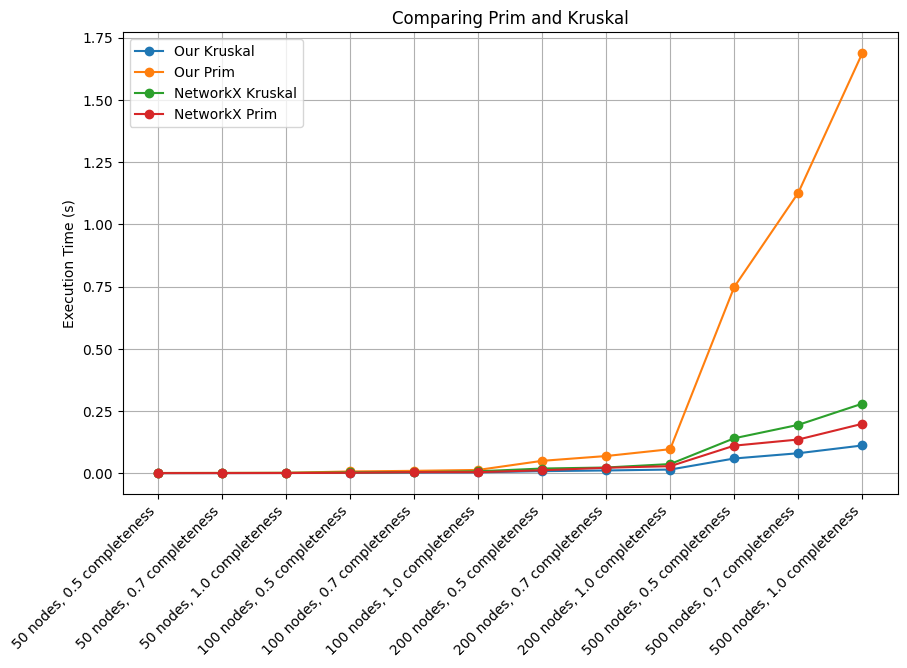

Підсумовуючи візуалізацію, можна сказати, що наш алгоритм Пріма, починаючи з 200 вершин, поступово займає більше часу для обробки. Це може бути пов'язано з використанням циклу while у нашому коді, який зупиняється лише тоді, коли кількість відвіданих вершин буде дорівнювати кількості вершин графу. Стосовно алгоритму Крускала можна замітити цікаву тенденцію, що при великій кількості вершин наш алгоритм справляється швидше, ніж алгоритм NetworkX. Можливо, це пов'язано з тим, що у нашому коді функції виконані більш просто.

### Завдання 2

#### Алгоритм Беллмана-Форда

Суть алгоритму Беллмана-Форда полягає у пошуку найкоротшого шляху від певної вершини до інших. Однак, на відміну від Дейкстри, алгоритм Беллмана-Форда дозволяє ребра від від'ємними значеннями. Також слід зазначити, що алгоритм припиняє роботу, якщо знайде негативний цикл у графі.

##### Наш код + опис

In [10]:
def bellman_ford(G: nx.Graph, start: int) -> dict[int, int]:
    """
    Creates Bellman-Ford algorithm to find
    the minimum distance from certain point.

    Parameters:
    G: nx.Graph, directed graph with weighted values;
    start: int, a number of point which should be the first.

    """
    shortest_paths = {node: float('inf') for node in G.nodes()}
    shortest_paths[start] = 0

    for _ in range(len(shortest_paths) - 1):
        updated = False
        for u, v, edge_data in G.edges(data=True):
            weight = edge_data['weight']
            if shortest_paths[u] != float('inf') and shortest_paths[u] + weight < shortest_paths[v]:
                shortest_paths[v] = shortest_paths[u] + weight
                updated = True
        if not updated:
            break

    for u, v, edge_data in G.edges(data=True):
        weight = edge_data['weight']
        if shortest_paths[u] != float('inf') and shortest_paths[u] + weight < shortest_paths[v]:
            return "Negative cycle detected"

    return {node: distance for node, distance in shortest_paths.items() if distance != float('inf')}


Функція полягає у створенні словнику з вершинами та початковими вагами як нескінченність і далі поступово додає ваги порівнюючи їх між собою (чим менше, тим краще). Тако є ймовірність перервати цикл, якщо жодне з ребер не змінилося під час ітерації і повернути текст, який вказує на наявність нескінченного циклу у графі, якщо такий існує.

##### Виведення

In [ ]:
print(bellman_ford(G, 0))

##### Порівняння алгоритмів Беллмана-Форда

Також нами була розроблена функція, яка порівнює наш алгоритм та алгоритм бібліотеки NetworkX. Як і в попередньому випадку, функція генерує графи рандомно.

In [ ]:
def compare_bellman_ford(num_of_nodes: int, completeness: float, iterations: int = 100):
    our_bf_times = []
    nx_bf_times = []

    with tqdm(total=iterations, desc=f"Processing {num_of_nodes} nodes, {completeness} completeness") as pbar:
        for _ in range(iterations):
            G = gnp_random_connected_graph(num_of_nodes, completeness, True)
            start_node = 0

            # Timing our Bellman-Ford implementation
            start_time = time.time()
            bellman_ford(G, start_node)
            our_bf_times.append(time.time() - start_time)

            # Timing NetworkX Bellman-Ford implementation
            start_time = time.time()
            try:
                bellman_ford_predecessor_and_distance(G, start_node)
            except:
                pass
            nx_bf_times.append(time.time() - start_time)

            pbar.update(1)  # Update progress bar

    return {
        "graph": G,
        "our_bf_times": our_bf_times,
        "nx_bf_times": nx_bf_times,
    }

# Store results for different graph sizes and densities
results_bf = {}

for num_nodes in [50, 100, 200]:
    for completeness in [0.5, 0.7, 1.0]:
        key = f"{num_nodes} nodes, {completeness} completeness"
        results_bf[key] = compare_bellman_ford(num_nodes, completeness, iterations=100)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

labels = list(results_bf.keys())  # Extract graph size & completeness labels
data = np.array([
    [np.mean(res[algo]) for algo in ["our_bf_times", "nx_bf_times"]]
    for res in results_bf.values()
])

for i, algo in enumerate(["Our Bellman-Ford", "NetworkX Bellman-Ford"]):
    ax.plot(labels, data[:, i], marker='o', label=algo)

ax.set_ylabel("Execution Time (s)")
ax.set_title("Comparing Bellman-Ford Algorithm")
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.grid()
plt.show()

###### Результати порівняння

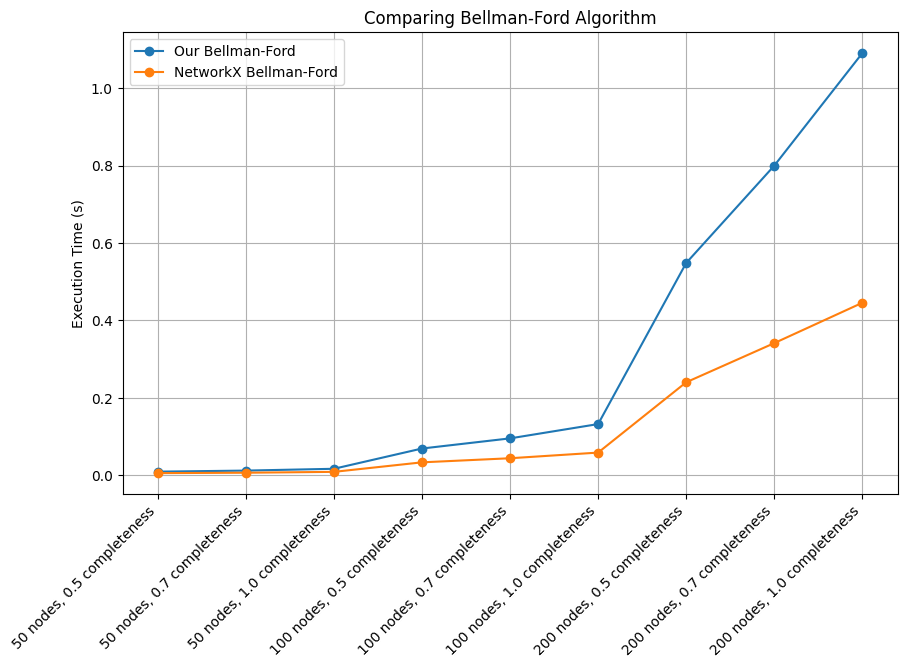

З графіку видно, що наш алгоритм при великих значеннях працює повільніше. Це може бути, тому що:


*   Ми створюємо новий словник всередині функції, який потребуватиме більше часу на створення зі збільшенням кількості вершин;
*   Ми проходимося по абсолютно усіх парах вершин, які мають ребро. До того, робимо це кілька разів, що, найімовірніше, і займає найбільше часу у роботі нашого алгоритму.



### Підсумок

*    Ми змогли зробити алгоритми Крускала та Пріма. Алгоритм Крускала справився набагато краще і, навіть, зміг праюцвати швидше, ніж алгоритм у NetworkX, тоді як алгоритм Пріма при більших значеннях працював помітно довше. Це може бути пов'язане з наявністю в алгоритмі циклу while, який може обтяжувати роботу коду;
*    Порівняно з алгоритмом NetworkX, наш алгоритм Беллмана-Форда при збільшенні кількості вершин працює помітно довше. Це може бути зв'язаним зі створенням великого списку у функції та постійних ітераціях по ребрах.

## 2. Бінарне дерево пошуку

### Наш код + опис

Початковий клас, який характеризує вершину.

In [13]:
class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """
        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

Основний клас, який вичисляє gini кожної вершини, (_gini), знаходить найкращий поділ, (_find_best_split), рекурсивно будує дерево, (_build_tree), тренує його, (fit), та передбачає, до якого типу вершина попаде, (predict).

In [14]:
class DecisionTreeClassifier:
    """Gini-based Decision Tree Classifier."""

    def __init__(self, max_depth: int = 20) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None

    @staticmethod
    def _gini(y: npt.NDArray) -> float:
        """Compute Gini impurity."""
        return 1 - sum((np.unique(y, return_counts=True)[1] / y.size) ** 2)

    @staticmethod
    def _find_best_split(X: npt.NDArray, y: npt.NDArray) -> tuple[int | None, float | None]:
        """Find best feature and threshold for split."""
        if np.unique(y).size == 1:
            return None, None

        gini_parent = DecisionTreeClassifier._gini(y)
        best_gini, best_feature, best_threshold = gini_parent, None, None

        for feature_idx in range(X.shape[1]):
            unique_values = np.unique(X[:, feature_idx])
            for threshold in unique_values:
                left_mask = X[:, feature_idx] <= threshold
                y_left, y_right = y[left_mask], y[~left_mask]
                if y_left.size == 0 or y_right.size == 0:
                    continue

                curr_split_gini = (
                    (y_left.size / y.size * DecisionTreeClassifier._gini(y_left)) +
                    (y_right.size / y.size * DecisionTreeClassifier._gini(y_right))
                )
                if curr_split_gini <= best_gini:
                    best_gini, best_feature, best_threshold = curr_split_gini, feature_idx, threshold

        return (best_feature, best_threshold) if best_gini < gini_parent else (None, None)

    def _build_tree(self, node: Node, depth: int = 0) -> None:
        """Recursively build decision tree."""
        if depth >= self.max_depth or np.unique(node.y).size == 1:
            return

        best_feature, best_threshold = self._find_best_split(node.X, node.y)
        if best_feature is None:
            return

        left_mask = node.X[:, best_feature] <= best_threshold
        X_left, y_left = node.X[left_mask], node.y[left_mask]
        X_right, y_right = node.X[~left_mask], node.y[~left_mask]

        if y_left.size == 0 or y_right.size == 0:
            return

        node.feature_index = best_feature
        node.threshold = best_threshold
        node.left, node.right = Node(X_left, y_left), Node(X_right, y_right)

        self._build_tree(node.left, depth + 1)
        self._build_tree(node.right, depth + 1)

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """Train decision tree on dataset."""
        self.number_of_classes = len(np.unique(y))
        self.tree = Node(X, y)
        self._build_tree(self.tree)

    def predict(self, X_test: npt.NDArray) -> list[int]:
        """Predict labels for test data."""
        predictions = []
        for sample in X_test:
            node = self.tree
            while node and (node.left or node.right):
                node = node.left if sample[node.feature_index] <= node.threshold else node.right
            predictions.append(np.argmax(np.bincount(node.y)))  # Predict most common label
        return predictions

Функція, що видає % вершин, які функція predict() змогла передбачити правильно.

In [15]:
def evaluate(model: DecisionTreeClassifier, X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    y_pred = model.predict(X_test)
    correct = sum(y_p == y_t for y_p, y_t in zip(y_pred, y_test))
    return float(correct / y_test.size)

### Тестування

In [ ]:
def test_model(model, data, name, test_size=0.2):
  X, y = data.data, data.target
  X, X_test, y, y_test = train_test_split(X, y, test_size = test_size)

  model.fit(X, y)
  return f"Accuracy of {model.__class__.__name__} model on {name} dataset is {round(evaluate(model, X_test, y_test) * 100, 1)}%"

sets = {"Iris": datasets.load_iris(),
        "Digits": datasets.load_digits(),
        "Diabetes": datasets.load_wine(),
        "Breast cancer": datasets.load_breast_cancer()
        }
for name, dataset in sets.items():
  print(test_model(DecisionTreeClassifier(), dataset, name))

### Візуалізація

In [ ]:
def visualize_tree(node, depth=0):
    """Recursively build Graphviz DOT format"""
    if node is None:
        return ""

    label = f"Feature {node.feature_index} <= {node.threshold}\nSamples: {node.y.size}\nValues: {np.bincount(node.y, minlength=3)}"

    node_id = f"node{depth}_{id(node)}"

    left_subtree = visualize_tree(node.left, depth + 1)
    right_subtree = visualize_tree(node.right, depth + 1)

    dot_string = f'"{node_id}" [label="{label}", shape=box];\n'

    if node.left:
        left_id = f"node{depth+1}_{id(node.left)}"
        dot_string += f'"{node_id}" -> "{left_id}";\n' + left_subtree

    if node.right:
        right_id = f"node{depth+1}_{id(node.right)}"
        dot_string += f'"{node_id}" -> "{right_id}";\n' + right_subtree

    return dot_string

def export_graphviz_tree(classifier):
    """Generate and render Graphviz representation of a custom decision tree"""
    dot_string = "digraph DecisionTree {\n"
    dot_string += visualize_tree(classifier.tree)
    dot_string += "}\n"

    graph = graphviz.Source(dot_string)
    return graph

# Generate and visualize the tree
data = datasets.load_iris()

X, y = data.data, data.target
X, X_test, y, y_test = train_test_split(X, y, test_size=0.20)

test = DecisionTreeClassifier()
test.fit(X, y)

graph = export_graphviz_tree(test)
graph.render("custom_decision_tree")
graph

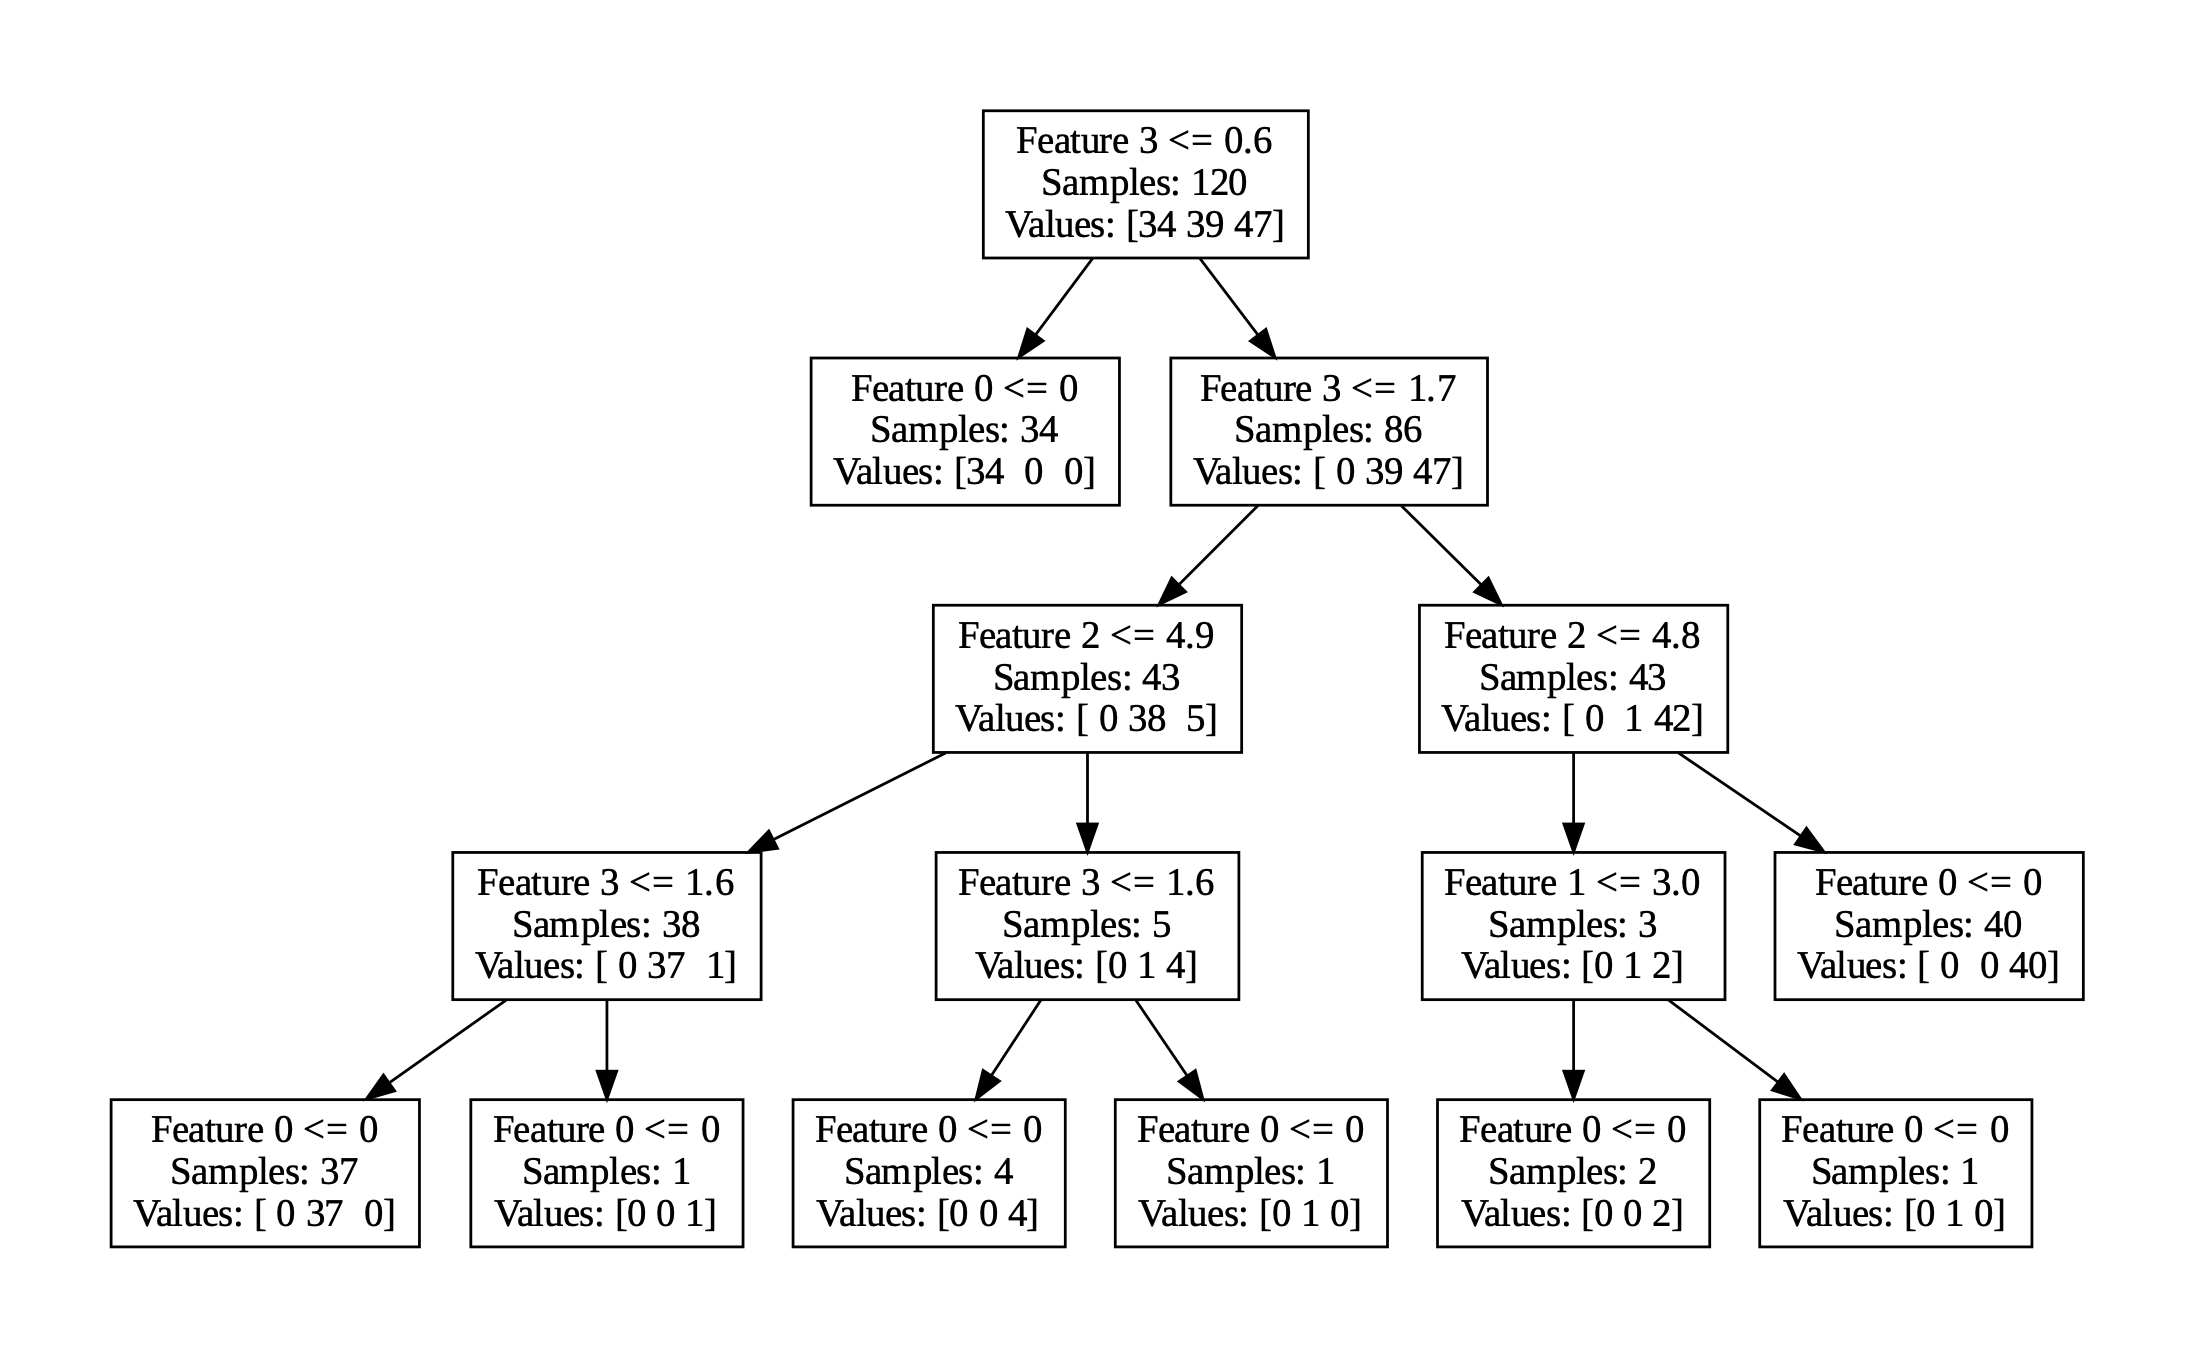

### Висновок

Зважаючи на порівняння тестувань та візуалізацію, можна сказати, що наш алгоритм прийняття рішень дуже добре працює, а сам `DecisionTreeClassifier` може сказати правильну відповідь у 80% випадках та більше.